2022-12-09 21:43:15.407 
  command:

    streamlit run C:\Users\jan.aalbu\Anaconda3\envs\geohjelp\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


0.743261532322361
1.486523064644722
2.2297845969670833
2.973046129289444
3.716307661611805


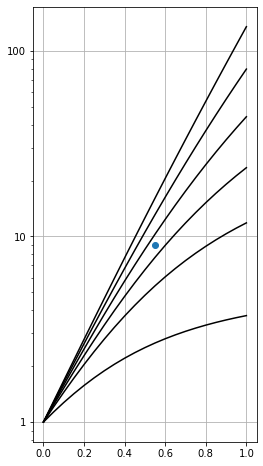

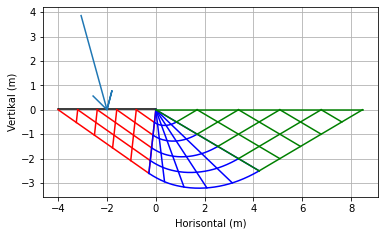

ModuleNotFoundError: No module named 'grunntrykk'

In [1]:
import math
import pandas as pd
import numpy as np
import bearing
import grunntrykk
from matplotlib import pyplot as plt

# Utrekning av bæreevne

## Styrkeparametere og materialfaktor

In [ ]:
#Friksjonsvinkel i grader
friksjonsvinkel_grader = 42 
#Attraksjon i kPa
attraksjon = 10
#Materialfaktor
gamma_m = 1.3
#Tyngdetetther over fundament kN/m3 
gamma_over = 18 
#Tyngetetthett under fundament kN/m3 
gamma_under = 18 

tan_ro = round(math.tan(math.radians(friksjonsvinkel_grader)),2) / gamma_m
print(f'Dimensjonerende tan_phi -> tan_ro : {round(tan_ro,2)}')

## Terreng og geometri
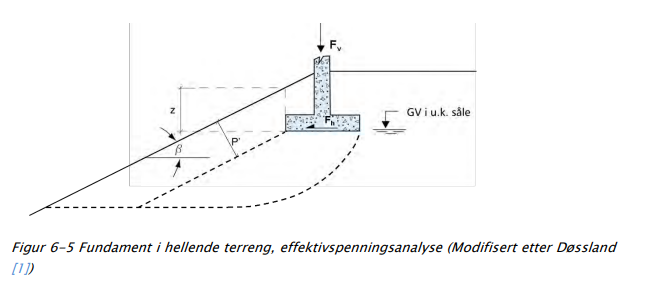

In [ ]:
#Gir inn hellingsforholdet for fylling frammom fundament (beta)
hellingsforhold = 1/1.5
#Hellinger for utplotting av bærevne for forskjellig helling
hellingsgrader_liste = range(26,39, 2)
hellingsforhold_liste = []
helling_i_radianer = math.atan(hellingsforhold)
helning_i_grader = math.degrees(helling_i_radianer)
for i in hellingsgrader_liste:
    hellingsforhold_liste.append(round(math.tan(math.radians(i)),2))
overlagring = 0.5 #m

print(f'Helling i radianer: {round(helling_i_radianer,1)}')
print(f'Helling i grader: {round(helning_i_grader,1)}')

## Laster
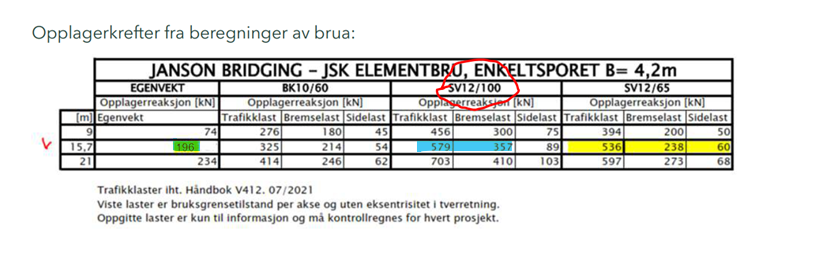

In [ ]:
#Laster i kN
Nv = {
    'egenvekt':196,
    'trafikklast':579
}
Nh =  {
    'bremselast':357
}

lastfaktor = 1.15

## Fundamentgeometri

In [ ]:
#Fundamentlengde i meter ("lengde normalt på senterlinje")
l_fund = 4.2
#Effektiv fundamentbredde i meter
b0 = 2.5
#Liste av mulig b0 for plotting
b0_liste = [1, 1.5, 2, 2.5, 3]


## Utrekning av grunntrykk

In [ ]:
#Samla vertikallaster (kN)
Nv_sum = sum(Nv.values())
#Samla horisontallaster (kN)
Nh_sum = sum(Nh.values())
#Samla vertikallaster inkludert lastfaktor per meter (kN/m)
Fv = (Nv_sum/l_fund) * lastfaktor
Fh = (Nh_sum/l_fund) * lastfaktor
#Vertiaklspenning under fundament (kPa)
qv = Fv / b0
#Horisontalspenning under funament (kPa)
tau_h = Fh / b0

#Samling i dict for plotting
qv_dict = {}
qv_liste = []
for i in b0_liste:
    qv_dict[i] = round(Fv / i,1)
    qv_liste.append(round(Fv / i,1))


## Utrekna utleda verdider for bæreevneberekning

In [ ]:
r_b = tau_h/ ((qv + attraksjon) * tan_ro)
nq, ng = grunntrykk.n_fakt(tan_ro, r_b_, helling=10000)
fsa, fsq = grunntrykk.f_reduksjon(hellingsforhold)
p_merka = overlagring * gamma_under


## Funksjon for berekning av bæreevne for hellende trerreng

In [ ]:
def sigma_hellende(fsq, fsa, nq, ng, gamma_under, b0, attraksjon, p_merka):
    return round((fsq*((nq*p_merka + (0.5*ng*gamma_under*b0))) + (((nq*fsa)-1)*attraksjon)),1)

## Plotting av grunntrykk mot bæreevne

In [ ]:
def bæreevne_plot(fsq, fsa, nq, ng, gamma_under, i, attraksjon, p_merka, helling):
    fig, ax = plt.subplots(figsize=(12,8))
    for helling in hellingsforhold_liste:
        fsa, fsq = grunntrykk.f_reduksjon(helling)
        for i in b0_liste:
            sigma_dict[i] = round(sigma_hellende(fsq, fsa, nq, ng, gamma_under, i, attraksjon, p_merka),1)
        ax.annotate('\u03C3\' for \u03B2 = 1/'+str((round((1/helling),1))), (i-0.3,max(sigma_dict.values())))
        ax.plot(sigma_dict.keys(), sigma_dict.values(), color='r')


    ax.plot(qv_dict.keys(), qv_dict.values(), color='b', label="Midlere vertikaltrykk under fundament (kPa)")
    ax.set_ylabel('Spenning (kPa)')
    ax.set_xlabel('Effektiv fundamentbredde (b0) (m)')
    ax.legend()
    ax.grid()
    fig.suptitle('Bærerevne ved forskjellige hellinger framfor fundament')

bæreevne_plot(fsq, fsa, nq, ng, gamma_under, i, attraksjon, p_merka, helling)    

## Sjekk at valgt b0 gir tilstrekkelig bærrevne

In [ ]:
print(f'Valgt b0: {b0} m')
print(f'Valgt helling: 1/{(round((1/hellingsforhold),1))}')
print(f'Valgt fundamentdjupne: {overlagring} m')
print('\n')
print('-------Resultater-------')
print('\n')
print(f'Fundamentruhet rb: {round(r_b,2)}')
print(f'NQ: {round(nq,1)}   |  Ngamma: {round(ng,1)}')
print(f'fsq: {round(fsq,2)}   |  fsa: {round(fsa,2)}')
print(f'    qv = {round(qv,1)} kPa')
sigma_h = sigma_hellende(fsq, fsa, nq, ng, gamma_under, b0, attraksjon, p_merka)
print(f'    \u03C3\' = {sigma_h} kPa')
if sigma_h > qv:
    print(f'Bæreevne er ok')
else:
    print(f'Bærrevne er for lav')